# Inverse Kinematics tutorial

we'll demonstrate inverse kinematics on a baxter robot

## Setup

In [1]:
import numpy as np
from pykin.robots.bimanual import Bimanual
from pykin.kinematics.transform import Transform
from pykin.utils import plot_utils as plt
from pykin.utils.transform_utils import compute_pose_error

In [2]:
file_path = '../asset/urdf/baxter/baxter.urdf'

robot = Bimanual(file_path, Transform(rot=[0.0, 0.0, 0.0], pos=[0, 0, 0]))
visible_collision = True

Set from base frame to end effector frame

In [3]:
robot.setup_link_name("base", "right_wrist")
robot.setup_link_name("base", "left_wrist")

In [4]:
# set the angles you want
head_thetas =  np.zeros(1)
right_arm_thetas = np.array([-np.pi/4 , 0, 0, 0, 0 , 0 ,0])
left_arm_thetas = np.array([np.pi/4 , 0, 0, 0, 0 , 0 ,0])

### Compute the forward kinematics to set the robot's target pose.

In [5]:
thetas = np.concatenate((head_thetas ,right_arm_thetas ,left_arm_thetas))
target_transformations = robot.forward_kin(thetas)

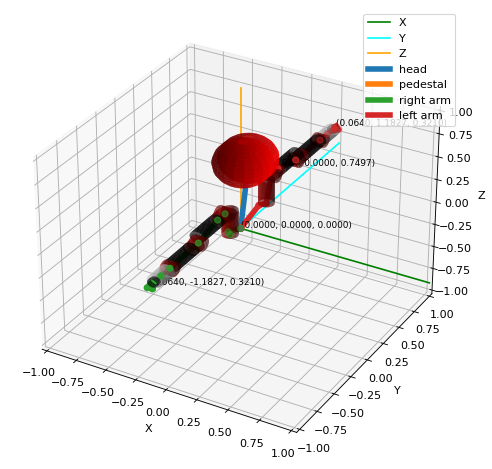

In [6]:
fig, ax = plt.init_3d_figure()
plt.plot_robot(robot, 
               ax=ax,
               transformations=target_transformations, 
               visible_collision=visible_collision)
ax.legend()

## Compute Inverse Kinematics

### For compute IK solution, you must set robot's pose
First, you must set joint initial angles using np.random.randn

In [7]:
init_thetas = np.random.randn(7)

### Use FK to find the end effector pose you want

In [8]:
target_pose = { "right": robot.get_eef_pose(target_transformations)["right"], 
                "left" : robot.get_eef_pose(target_transformations)["left"]}

Target pose's shape for Inverse Kinematics is (7,)

Combine position(x,y,z) and orientation(quaternion: w,x,y,z)

In [9]:
target_pose

{'right': array([ 0.06402554, -1.18271238,  0.320976  ,  0.49999954,  0.50000046,
         0.49999954, -0.50000046]),
 'left': array([ 0.06402554,  1.18271238,  0.320976  ,  0.49999954, -0.50000046,
         0.49999954,  0.50000046])}

### Get the target joints using inverse kinematics.

Iterators is the number of iterations to update the joint angle 

WorkingTime is how long this function takes to execute.

NR means to Newton Raphson and LM means to levenberg-marquardt.

levenberg-marquardt Method

In [10]:
ik_LM_result = robot.inverse_kin(
    init_thetas, 
    target_pose, 
    method="LM", 
    maxIter=100)
print(ik_LM_result)

Iterators : 100
WorkingTime[inverse_kinematics]: 0.2301 sec

Iterators : 50
WorkingTime[inverse_kinematics]: 0.1018 sec

{'right': array([ 2.11875844, -3.23640876, -1.48033052,  0.24064678, -1.25964404,
       -0.04615442, -0.42179396]), 'left': array([ 7.85402208e-01, -7.09571273e-06, -6.59348629e-03,  4.53370639e-05,
        5.17543780e-02, -3.84074536e-05, -4.51608272e-02])}


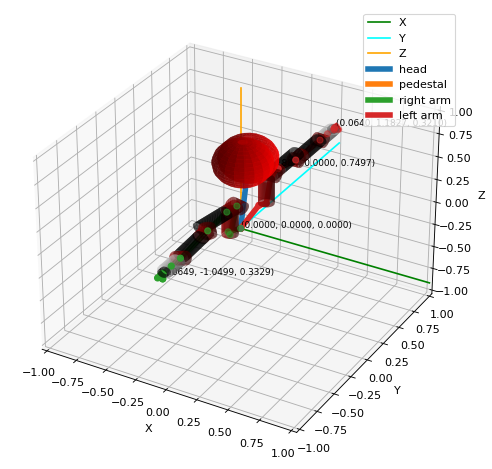

In [11]:
thetas_LM = np.concatenate((head_thetas, ik_LM_result["right"], ik_LM_result["left"]))
result_fk_LM = robot.forward_kin(thetas_LM)
_, ax = plt.init_3d_figure("LM IK Result")
plt.plot_robot(robot, ax, result_fk_LM, 
               visible_collision=visible_collision)

Newton Raphson method

In [12]:
ik_NR_result = robot.inverse_kin(
    init_thetas, 
    target_pose, 
    method="NR", 
    maxIter=100)
print(ik_NR_result)

Iterators : 27
WorkingTime[inverse_kinematics]: 0.0611 sec

Iterators : 27
WorkingTime[inverse_kinematics]: 0.0519 sec

{'right': array([-6.86299525,  0.17494745,  4.37298287, -6.01135909,  1.3712244 ,
       -0.09472414,  0.56976101]), 'left': array([-5.52865348,  0.3713455 ,  3.04482096, -5.9163576 ,  3.78971284,
       -0.0071682 , -0.55794992])}


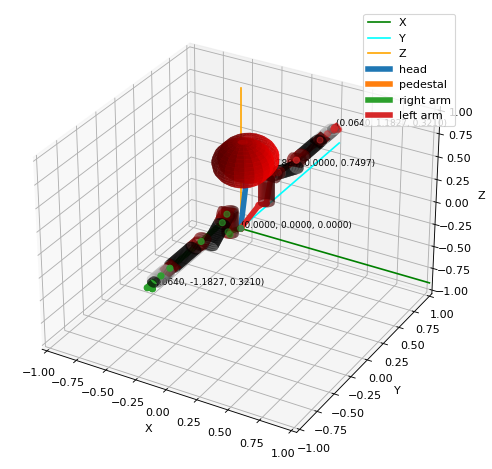

In [13]:
thetas_NR = np.concatenate((head_thetas, ik_NR_result["right"], ik_NR_result["left"]))
result_fk_NR = robot.forward_kin(thetas_NR)
_, ax = plt.init_3d_figure("NR IK Result")
plt.plot_robot(robot, ax, result_fk_NR,
               visible_collision=visible_collision)

Error between target pose and pose obtained by solving ik

In [14]:
err = {}
for arm in robot.arm_type:
    err[arm+"_NR_error"] = compute_pose_error(
        target_transformations[robot.eef_name[arm]].h_mat,
        result_fk_NR[robot.eef_name[arm]].h_mat)

    err[arm+"_LM_error"] = compute_pose_error(
        target_transformations[robot.eef_name[arm]].h_mat,
        result_fk_LM[robot.eef_name[arm]].h_mat)

for error_name, value in err.items():
    print(f"{error_name} : {value}")

plt.show_figure()

right_NR_error : 1.1111537098782626e-06
right_LM_error : 0.1577021154758903
left_NR_error : 8.963476309488038e-07
left_LM_error : 3.7715482135243686e-06
